In [1]:
import tifffile  # load and save tifs

# work with arrays / images
import numpy as np
import skimage

# work with dataframes (basically spreadsheets)
import pandas as pd

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# generally useful python libraries
from pathlib import Path
from collections import defaultdict

In [2]:
BASE_PATH = Path(r"C:\FeedbackControl\toettchlab_pyclm\data")
file_stem = "CC_mdck_ktr"

raw = tifffile.imread(BASE_PATH / f"{file_stem}.tif")
segmented = tifffile.imread(BASE_PATH / "masks" / f"{file_stem}_masks.tif")
tracks = pd.read_csv(BASE_PATH / "tracks" / f"{file_stem}_tracks.csv")

print(f"Raw has dimensions {raw.shape}")
print(f"Segmented has dimensions{segmented.shape}")
print(f"Tracks look like:")
print(tracks.head(5))

Raw has dimensions (133, 2, 415, 615)
Segmented has dimensions(133, 415, 615)
Tracks look like:
   label   area      px_y        px_x  frame  tree_id  track_id
0      1  164.0  4.457317   19.378049      0        0         0
1      2  252.0  6.361111   48.202381      0        1         1
2      3  253.0  5.561265  187.529644      0        2         2
3      4  202.0  3.910891  234.024752      0        3         3
4      5  170.0  5.517647  269.170588      0        4         4


In [19]:
"""
Data processing: combining raw and segmented data with tracks
"""

REGIONPROPS_COLUMNS = {"intensity_mean", }

def get_intensity_data(raw_data, segmented_data, regionprops_columns):

    regionprops_columns = set(regionprops_columns)
    regionprops_columns.add("label")

    data_dict = defaultdict(list)

    """
    Iterate through each frame, collecting data on each segmented
    """
    for frame in range(segmented.shape[0]):
        label_image = segmented_data[frame]
        intensity_image = raw_data[frame]
        intensity_image = np.moveaxis(intensity_image, 0, -1)  # moves the channel axis to the end

        props = skimage.measure.regionprops_table(label_image,
                                                  intensity_image,
                                                  properties=regionprops_columns,)

        for label, data in props.items():
            data_dict[label].extend(data)

        n_regions = len(props['label'])
        data_dict["frame"].extend([frame for _ in range(n_regions)])

    return pd.DataFrame(data_dict)

intensity_data = get_intensity_data(raw, segmented, REGIONPROPS_COLUMNS)
tracked_data = pd.merge(tracks, intensity_data, on=["label", "frame"])

tracked_data = tracked_data.rename(columns = {
    "intensity_mean-0": "nucleus intensity",
    "intensity_mean-1": "nucleus ktr intensity"
})

print(tracked_data)


       label   area        px_y        px_x  frame  tree_id  track_id  \
0          1  164.0    4.457317   19.378049      0        0         0   
1          2  252.0    6.361111   48.202381      0        1         1   
2          3  253.0    5.561265  187.529644      0        2         2   
3          4  202.0    3.910891  234.024752      0        3         3   
4          5  170.0    5.517647  269.170588      0        4         4   
...      ...    ...         ...         ...    ...      ...       ...   
23623    168  250.0  400.544000  589.368000    132      681       681   
23624    169  248.0  403.463710   27.612903    132      431       431   
23625    170  233.0  406.845494   59.909871    132      682       682   
23626    171  189.0  408.206349  545.396825    132      812       812   
23627    172  205.0  409.834146  340.663415    132      857       857   

       nucleus intensity  nucleus ktr intensity  
0            1570.256098            3017.384146  
1             951.22619

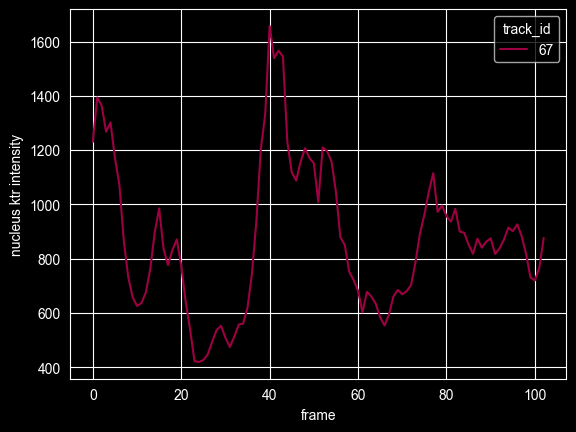

In [28]:
sampled_trackids = [67]
data_subset = tracked_data[tracked_data["track_id"].isin(sampled_trackids)]

sns.lineplot(data_subset, x="frame", y="nucleus ktr intensity", hue="track_id", palette="Spectral", errorbar=None)
plt.show()

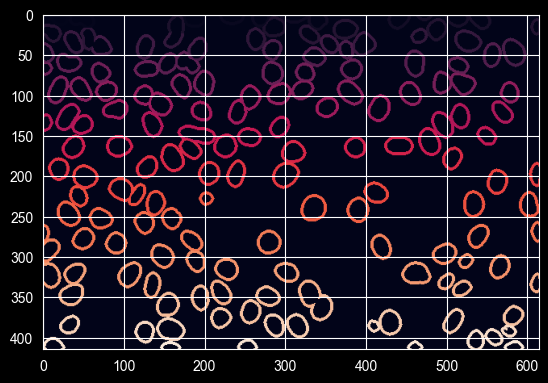

       label   area        px_y        px_x  frame  tree_id  track_id  \
0          1  164.0    4.457317   19.378049      0        0         0   
1          2  252.0    6.361111   48.202381      0        1         1   
2          3  253.0    5.561265  187.529644      0        2         2   
3          4  202.0    3.910891  234.024752      0        3         3   
4          5  170.0    5.517647  269.170588      0        4         4   
...      ...    ...         ...         ...    ...      ...       ...   
23623    168  250.0  400.544000  589.368000    132      681       681   
23624    169  248.0  403.463710   27.612903    132      431       431   
23625    170  233.0  406.845494   59.909871    132      682       682   
23626    171  189.0  408.206349  545.396825    132      812       812   
23627    172  205.0  409.834146  340.663415    132      857       857   

       nucleus intensity  nucleus ktr intensity  donut nucleus intensity  \
0            1570.256098            3017.384146

In [20]:
from skimage.segmentation import expand_labels

label_expanded_image = np.array([expand_labels(seg_frame, 4) for seg_frame in segmented])
donut_image = label_expanded_image - segmented

plt.imshow(donut_image[0])
plt.show()

donut_data = get_intensity_data(raw, donut_image, ["intensity_mean"])

new_tracked_data = pd.merge(tracked_data, donut_data, on=["label", "frame"])

new_tracked_data = new_tracked_data.rename(columns = {
    "intensity_mean-0": "donut nucleus intensity",
    "intensity_mean-1": "donut ktr intensity"
})

new_tracked_data["nuc/cyt"] = new_tracked_data["nucleus ktr intensity"] / new_tracked_data["donut ktr intensity"]

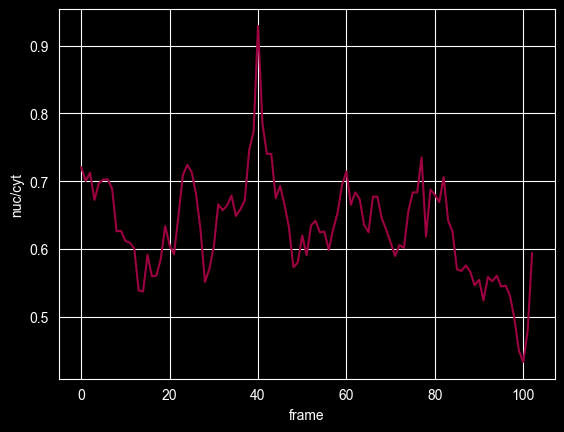

In [29]:
# t_count = new_tracked_data.groupby("track_id")["frame"].count()
# long_ids = t_count[t_count > 100].index

sampled_trackids = [67]
data_subset = new_tracked_data[new_tracked_data["track_id"].isin(sampled_trackids)]

sns.lineplot(data_subset, x="frame", y="nuc/cyt", hue="track_id", palette="Spectral", errorbar=None, legend=False)
plt.show()